<a href="https://colab.research.google.com/github/heroideallstar/MachineLearn_Alura/blob/main/NLP_sentimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'imdb-ptbr:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F51413%2F95829%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T141828Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D34b69dfeee17a40278cb2e72a3bf52808d374bd20ce1bde5a0c0462b1a7dcfcfa5a595e8442a1b5977b38cf4b222bdba0a1eba5180c407220c31daea1baa516b295e4472bbbf80c3b798910dd175bcb1a76ef389e036afedef7bf68088a44668c45033419177a696ca241c0f27e4f8935e75c19b00bbc394592cdc18470e9d5a785c3783170132062970c45790cc479d49fb35be96a185ca3c4ce790a7e28bd116827dc8eb1d78086c49bbd360875bafe6243378e528c0635ba4b7c346ba0f43586640adb3be4d005dc7b823cec30c088b14dbb08965fa553ae5aa18f4559425b2e4a5f17d7fc02a2a1dcd5c6ba5885ac41777d8256839f45c4d0efd09a88e37'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 50783959 bytes downloaded
Downloaded and uncompressed: imdb-ptbr
Data source import complete.


# NLP - Processamento de Linguagem Natural
Criação de um modelo de interpretação de linguagem natural: a partir da base de dados do IMDb iremos realizar um levantamento do sentimento das pessoas que avaliaram os filmes.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
resenha = pd.read_csv('/kaggle/input/imdb-ptbr/imdb-reviews-pt-br.csv')
resenha.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
print("Negativa \n")
print(resenha.text_pt[189])

Negativa 

Este é sem dúvida o pior filme que eu já vi. E acredite em mim, eu vi muitos filmes. A reviravolta inacreditável que o filme faz - passando de um extremamente mau filme "Formas de vida alienígenas habitam a terra", com um filme que tenta espalhar um arquicristiano "O dia do julgamento está próximo, buscar Jesus ou queimar por toda a eternidade em as dívidas ardentes do inferno "mensagem - deixou-me atordoado depois de ter sido atormentado por 85 minutos. Até mesmo os cristãos religiosos devem se envergonhar ou ficar furiosos ao ver suas crenças postadas dessa maneira. Eu não sabia o que fazer comigo quando assisti a atuação horrível que poderia ter sido realizada por crianças de 7 anos de idade. Simplesmente repugnante. Eu não sou cristão nem muito religioso. Mas se eu estivesse, não teria mais medo do Inferno. Rich Christiano mostrou ser algo muito pior.


In [7]:
print("Positiva \n")
print(resenha.text_pt[49002])

Positiva 

Crescendo em Nova York no final dos anos 80 e início dos anos 90, posso dizer pessoalmente que este é um dos documentários mais importantes feitos para cobrir esse lugar neste período de tempo. Não Madonna não veio com a idéia de Voguing, mas é de onde ela tirou! Em vez de combater a violência uns dos outros ou em brigas de gato, o voguing permitia que as pessoas "lutassem" dentro dos confins de tudo, menos que tocassem umas às outras, o que justificaria uma desqualificação automática. Vendo este tipo de extraordinariamente talentosas / bem orquestradas "jogadas" nos clubes foi nada menos do que espetacular e todos os grandes nomes de antigamente estão aqui ... Pepper La Beija, Paris Duprée, Xtragavaganza, etc. ..tudo comemorado nos gostos de peças de época como a música de Malcom McLarens "Deep in Vogue" ... não importava quem você era, ou de onde você era porque quando você passava por aquelas portas nesse "reino mágico" de De certa forma, você se tornou parte de algo maio

In [8]:
print(resenha.sentiment.value_counts())

sentiment
neg    24765
pos    24694
Name: count, dtype: int64


In [9]:
classificacao = resenha["sentiment"].replace(["neg", "pos"], [0,1])

In [10]:
resenha["classificacao"] = classificacao

In [11]:
resenha.head()

,id,text_en,text_pt,sentiment,classificacao
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


In [12]:
resenha.tail()

,id,text_en,text_pt,sentiment,classificacao
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos,1
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos,1
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos,1
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos,1
49458,49460,Working-class romantic drama from director Mar...,O drama romântico da classe trabalhadora do di...,pos,1


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

## Um exemplo

In [14]:
texto = ['Assisti um filme ótimo', 'Assisti um filme ruim']
vetorizar = CountVectorizer(lowercase = False)
bag_of_words = vetorizar.fit_transform(texto)
bag_of_words

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

In [16]:
vetorizar.get_feature_names_out()

array(['Assisti', 'filme', 'ruim', 'um', 'ótimo'], dtype=object)

In [17]:
matriz_esparsa = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns = vetorizar.get_feature_names_out())

In [18]:
matriz_esparsa

,Assisti,filme,ruim,um,ótimo
0,1,1,0,1,1
1,1,1,1,1,0


## Aplicado ao IMDb

Vetorizando os dados de teste e de treino para que não corrermos o risco de alguma palavra não estar disponivel em uma analise futura.

In [19]:
vetorizar = CountVectorizer(lowercase = False, max_features = 50)
bag_of_words = vetorizar.fit_transform(resenha.text_pt)
print(bag_of_words.shape)

(49459, 50)


In [20]:
treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words, resenha.classificacao, random_state = 42)
regressão_logistica = LogisticRegression()
regressão_logistica.fit(treino, classe_treino)
acuracia = regressão_logistica.score(teste, classe_teste)
print(acuracia)

0.6583097452486858


# Função de PLN

In [21]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase = False, max_features = 50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])

    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words, texto[coluna_classificacao], random_state = 42)
    regressão_logistica = LogisticRegression()
    regressão_logistica.fit(treino, classe_treino)
    return regressão_logistica.score(teste, classe_teste)
print(classificar_texto(resenha,"text_pt", "classificacao"))

0.6583097452486858


In [22]:
%matplotlib inline
from wordcloud import WordCloud

In [23]:
todas_palavras =' '.join([texto for texto in resenha.text_pt])
nuvem_palavras = WordCloud(width= 800, height= 500,max_font_size = 110, collocations = False).generate(todas_palavras)

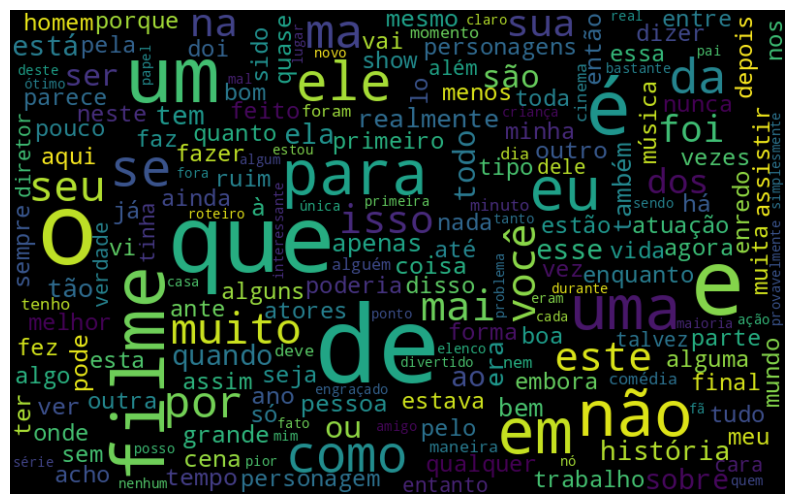

In [24]:
plt.figure(figsize=(10,7))
plt.imshow(nuvem_palavras, interpolation='bilinear')
plt.axis("off")
plt.show()

In [25]:
def nuvem_palavras_neg(texto, coluna_texto):
    texto_negativo = texto.query("sentiment == 'neg'")
    todas_palavras = ' '.join([texto for texto in texto_negativo[coluna_texto]])

    nuvem_palavras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [26]:
def nuvem_palavras_pos(texto, coluna_texto):
    texto_positivo = texto.query("sentiment == 'pos'")
    todas_palavras = ' '.join([texto for texto in texto_positivo[coluna_texto]])

    nuvem_palavras = WordCloud(width= 800, height= 500,
                              max_font_size = 110,
                              collocations = False).generate(todas_palavras)
    plt.figure(figsize=(10,7))
    plt.imshow(nuvem_palavras, interpolation='bilinear')
    plt.axis("off")
    plt.show()

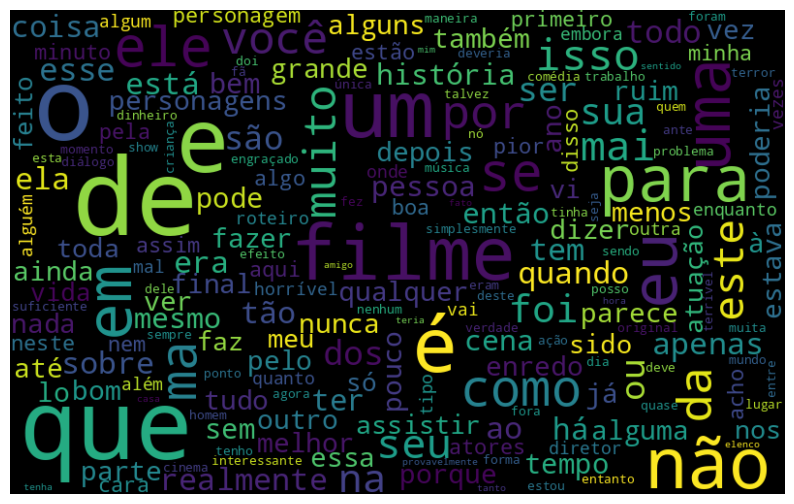

In [27]:
nuvem_palavras_neg(resenha, "text_pt")

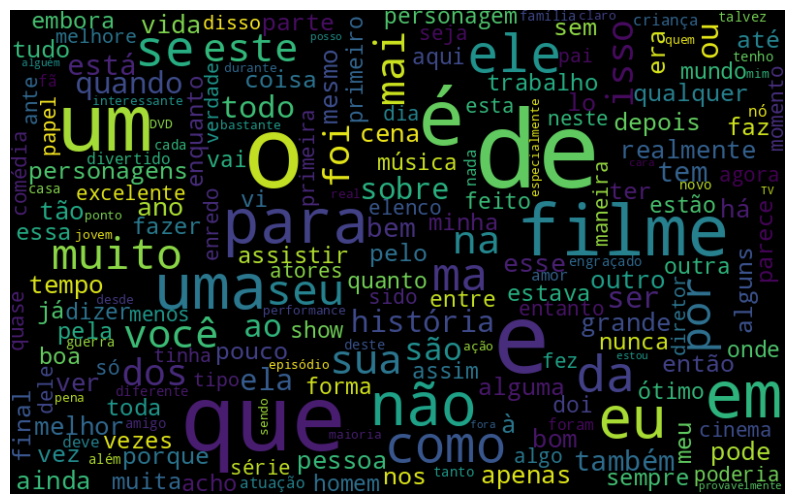

In [28]:
nuvem_palavras_pos(resenha, "text_pt")

## Diagrama de [Pareto](https://qualyteam.com/pb/blog/passo-a-passo-de-como-fazer-o-diagrama-de-pareto/)

In [29]:
import nltk

nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [30]:
frase = ["um filme bom", "um filme ruim"]
frequencia = nltk.FreqDist(frase)
frequencia

FreqDist({'um filme bom': 1, 'um filme ruim': 1})

In [31]:
from nltk import tokenize

In [32]:
frase = "Bem vindo ao mundo do PLN!"

token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(frase)
print(token_frase)

['Bem', 'vindo', 'ao', 'mundo', 'do', 'PLN!']


In [33]:
token_frase = token_espaco.tokenize(todas_palavras)
frequencia = nltk.FreqDist(token_frase)

In [ ]:
df_frequencia = pd.DataFrame({"palavra":list(frequencia.keys()), "frequencia": list(frequencia.values())})
df_frequencia.nlargest(columns = "frequencia", n = 10)

In [36]:
import seaborn as sns

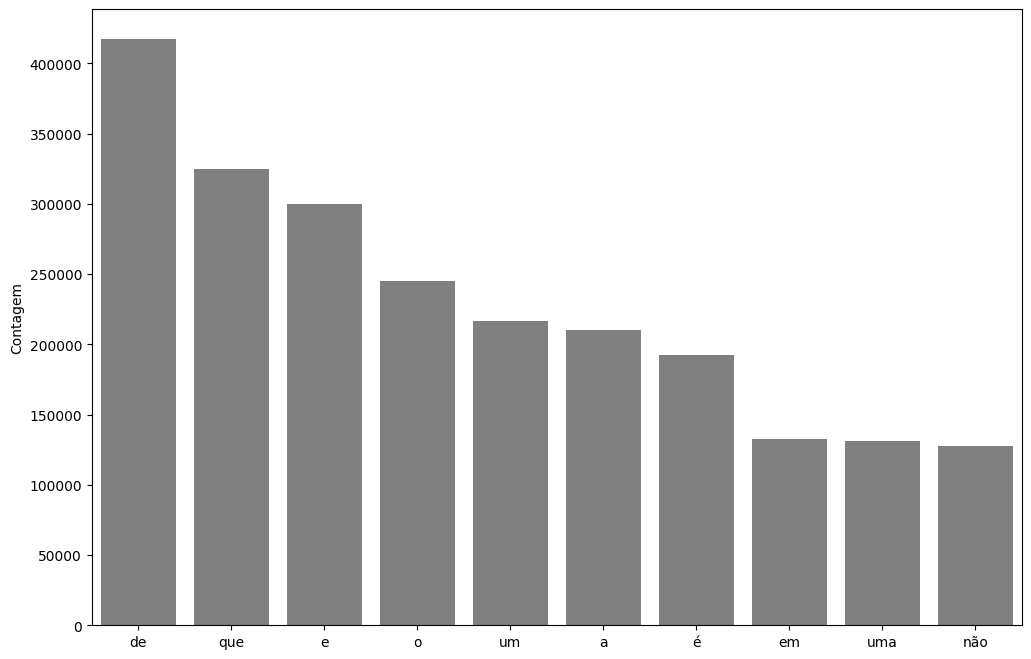

In [37]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequencia.nlargest(columns= "frequencia", n = 10), x = "palavra", y = "frequencia", color = 'gray')
ax.set(ylabel = "Contagem", xlabel = "")
plt.show()

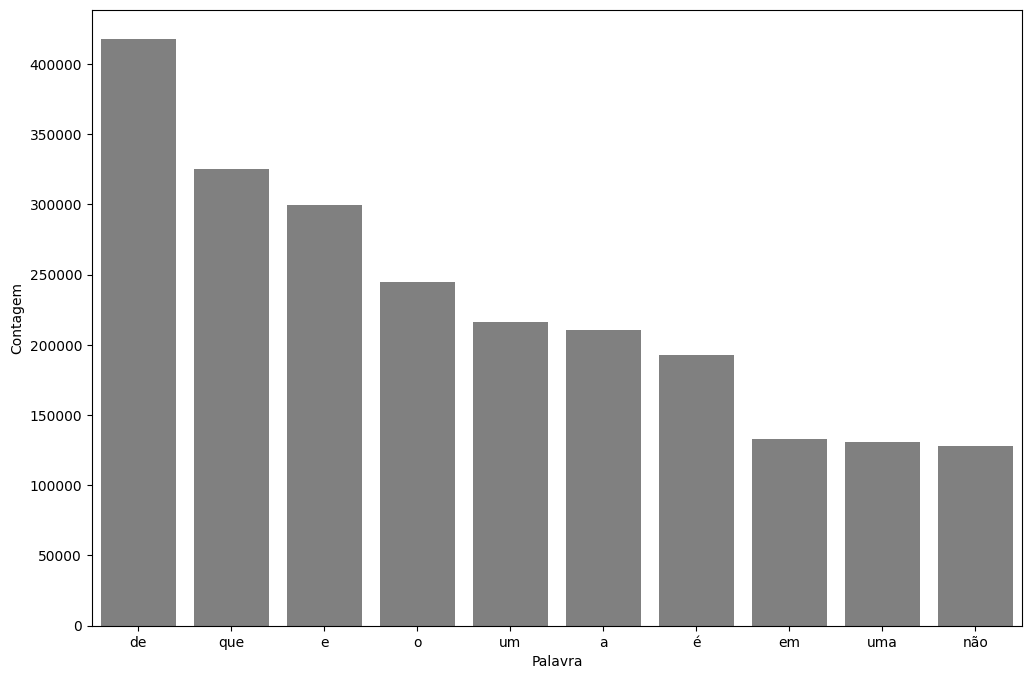

In [38]:
def pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                   "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()

pareto(resenha, "text_pt", 10)

## Tratando as informações

### Removendo StopWords

In [39]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")

frase_processada = list()
for opiniao in resenha.text_pt:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

resenha["tratamento_1"] = frase_processada

In [40]:
resenha.head()

,id,text_en,text_pt,sentiment,classificacao,tratamento_1
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece..."
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi..."
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve..."


In [41]:
classificar_texto(resenha, "tratamento_1", "classificacao")

0.6811160533764659

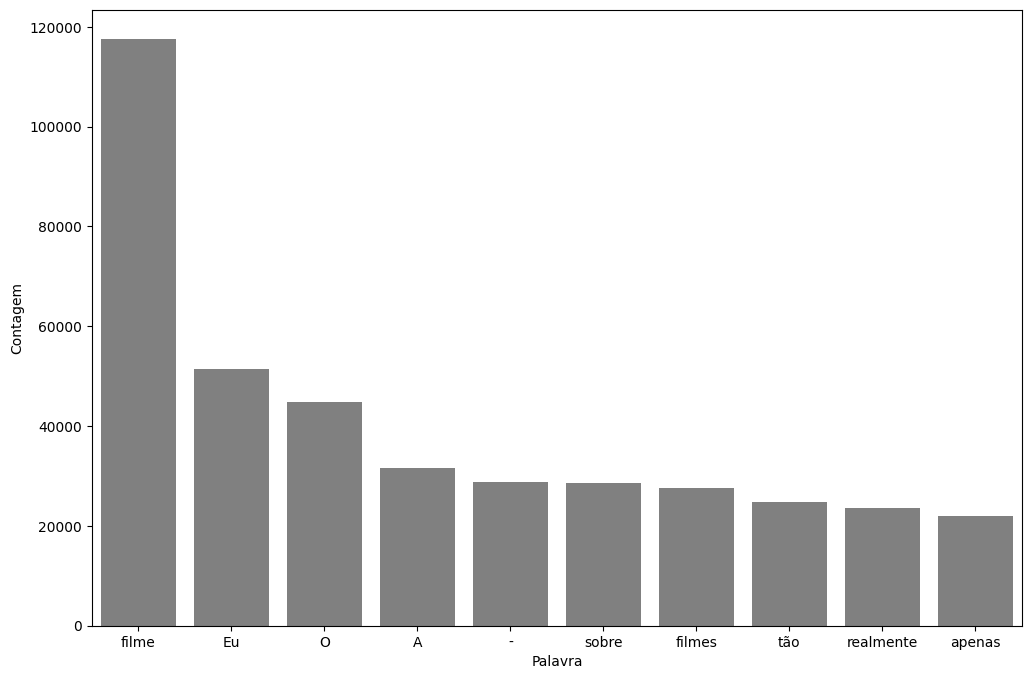

In [42]:
pareto(resenha,"tratamento_1", 10)

### Removendo pontuações

In [43]:
from string import punctuation
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

In [44]:
token_pontuacao = tokenize.WordPunctTokenizer()
token_espaco = tokenize.WhitespaceTokenizer()

In [45]:
pontuacao_stopwords = pontuacao + palavras_irrelevantes
frase_processada = list()
for opiniao in resenha["tratamento_1"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
resenha["tratamento_2"] = frase_processada

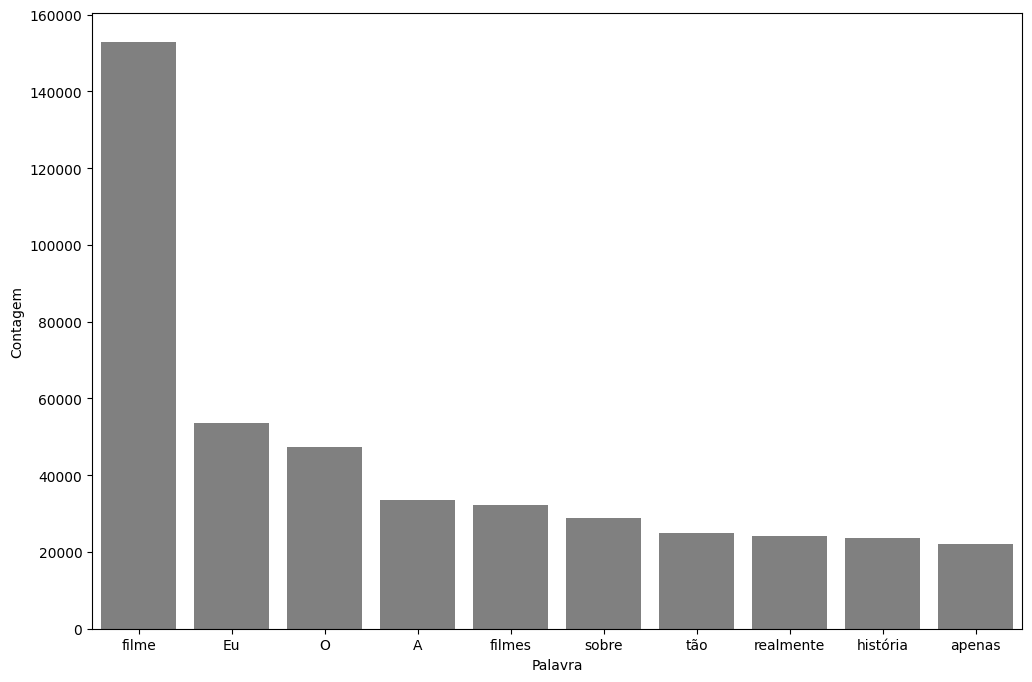

In [46]:
pareto(resenha, "tratamento_2", 10)

In [47]:
frase_processada = list()
for opiniao in resenha["tratamento_2"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

resenha["tratamento_3"] = frase_processada

In [48]:
resenha.head()

,id,text_en,text_pt,sentiment,classificacao,tratamento_1,tratamento_2,tratamento_3
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0,"Mais vez, Sr. Costner arrumou filme tempo nece...",Mais vez Sr Costner arrumou filme tempo necess...,vez sr costner arrumou filme tempo necessário ...
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0,Este exemplo motivo maioria filmes ação mesmos...,Este exemplo motivo maioria filmes ação mesmos...,exemplo motivo maioria filmes ação mesmos gené...
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0,"Primeiro tudo odeio raps imbecis, poderiam agi...",Primeiro tudo odeio raps imbecis poderiam agir...,primeiro tudo odeio raps imbecis poderiam agir...
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0,Nem Beatles puderam escrever músicas todos gos...,Nem Beatles puderam escrever músicas todos gos...,beatles puderam escrever músicas todos gostass...
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0,"Filmes fotos latão palavra apropriada eles, ve...",Filmes fotos latão palavra apropriada verdade ...,filmes fotos latão palavra apropriada verdade ...


In [49]:
acuracia_tratamento3 = classificar_texto(resenha, "tratamento_3", "classificacao")
print(acuracia_tratamento3)

0.6878285483218762


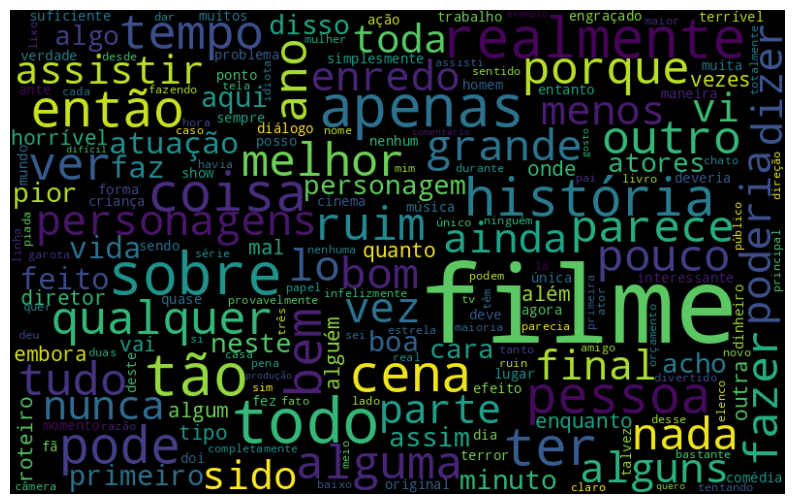

In [50]:
nuvem_palavras_neg(resenha, "tratamento_3")

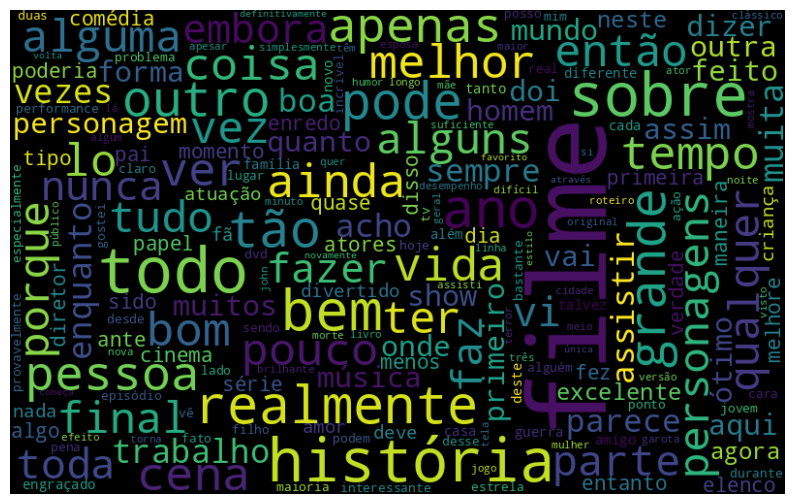

In [51]:
nuvem_palavras_pos(resenha, "tratamento_3")

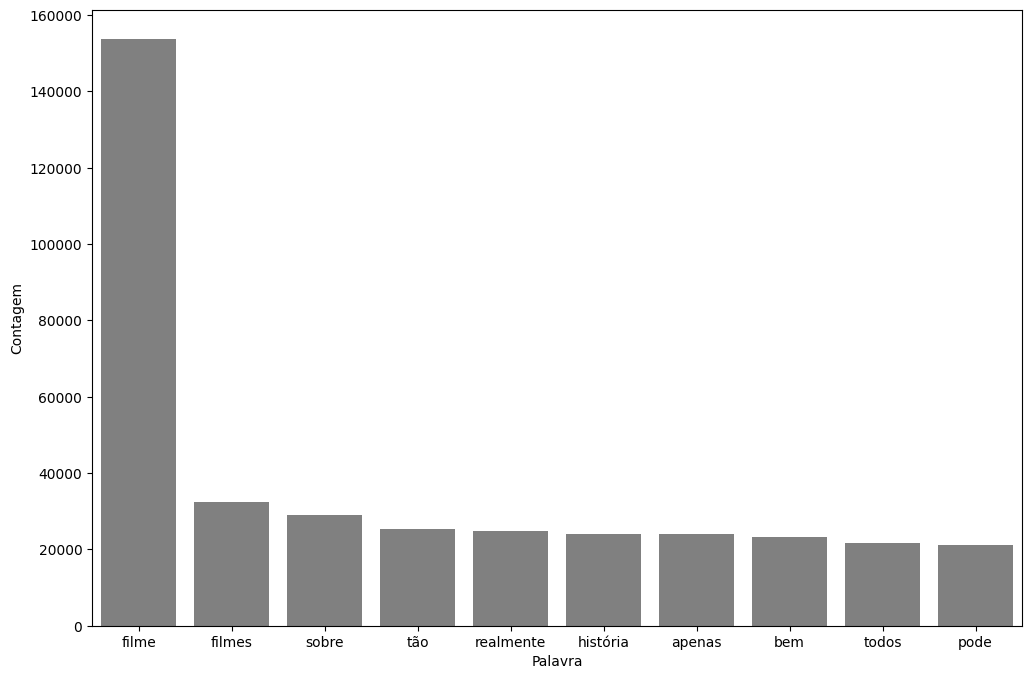

In [52]:
pareto(resenha, "tratamento_3", 10)

### Agrupando os prefixos e sufixos

In [53]:
stemmer = nltk.RSLPStemmer()
frase_processada = list()
for opiniao in resenha["tratamento_3"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))

resenha["tratamento_4"] = frase_processada

In [54]:
acuracia_tratamento4 = classificar_texto(resenha, "tratamento_4", "classificacao")
print(acuracia_tratamento4)
print(acuracia_tratamento3)

0.6956732713303679
0.6878285483218762


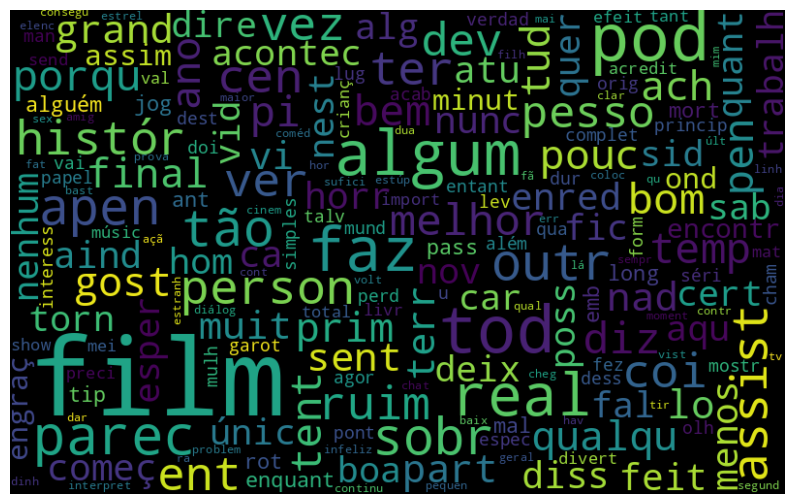

In [55]:
nuvem_palavras_neg(resenha, "tratamento_4")

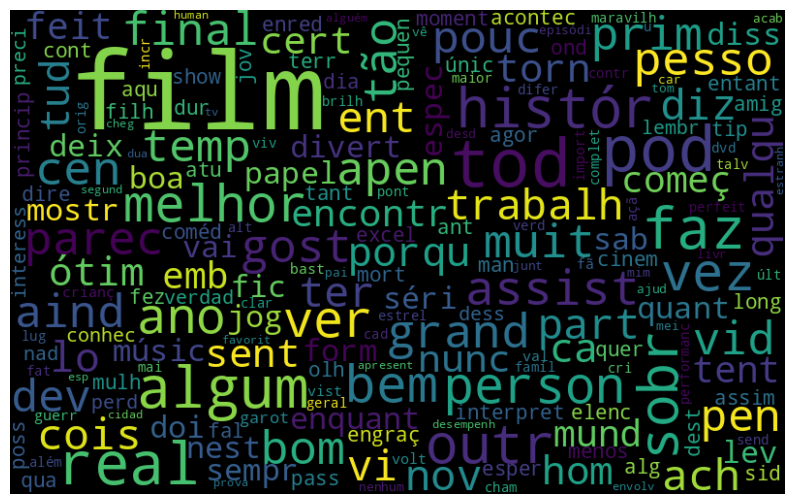

In [56]:
nuvem_palavras_pos(resenha, "tratamento_4")

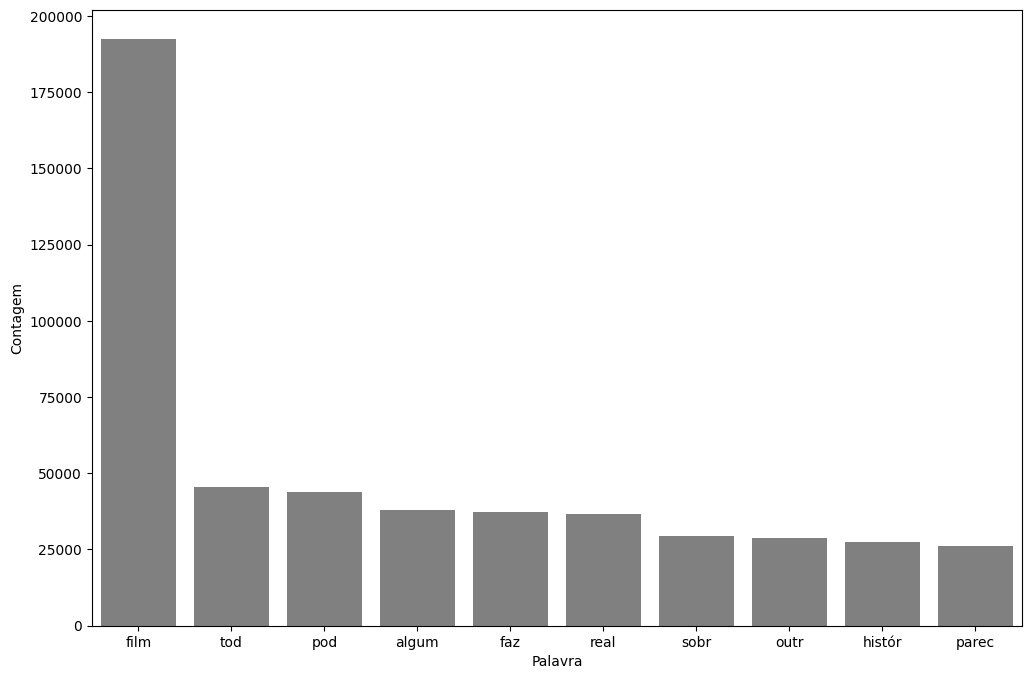

In [57]:
pareto(resenha, "tratamento_4", 10)

## TF-IDF ( Frequência dos Termos - Inverso da Frequência do Documento)

In [58]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [59]:
tfidf = TfidfVectorizer(lowercase=False, max_features=50)
tfidf_bruto = tfidf.fit_transform(resenha["text_pt"])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_bruto, resenha["classificacao"], random_state = 42)

regressão_logistica .fit(treino, classe_treino)
acuracia_tfidf_bruto = regressão_logistica .score(teste, classe_teste)
print(acuracia_tfidf_bruto)

0.6600889607763849


In [60]:
tfidf_tratados = tfidf.fit_transform(resenha["tratamento_4"])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_tratados, resenha["classificacao"], random_state = 42)

regressão_logistica.fit(treino, classe_treino)
acuracia_tfidf_tratados = regressão_logistica.score(teste, classe_teste)
print(acuracia_tfidf_tratados)

0.6964011322280631


In [61]:
from nltk import ngrams

In [62]:
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
vetor_tfidf = tfidf.fit_transform(resenha["tratamento_4"])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf, resenha["classificacao"], random_state = 42)
regressão_logistica.fit(treino, classe_treino)
acuracia_tfidf_ngrams = regressão_logistica.score(teste, classe_teste)
print(acuracia_tfidf_ngrams)

0.8854832187626365


In [63]:
tfidf = TfidfVectorizer(lowercase=False)
vetor_tfidf = tfidf.fit_transform(resenha["tratamento_4"])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf, resenha["classificacao"], random_state = 42)
regressão_logistica.fit(treino, classe_treino)
acuracia_tfidf = regressão_logistica.score(teste, classe_teste)
print(acuracia_tfidf)

0.8821674080064699


In [64]:
pesos = pd.DataFrame(
    regressão_logistica.coef_[0].T,
    index = tfidf.get_feature_names_out()
)
pesos.nlargest(50, 0)

,0
ótim,8.232360
excel,8.011294
perfeit,6.589780
incr,6.241187
favorit,5.777302
maravilh,5.227106
ador,4.726396
divert,4.650806
brilh,4.301170
definitiv,4.211725


In [65]:
pesos.nsmallest(10,0)

,0
pi,-9.290660
ruim,-9.277783
chat,-6.835416
horr,-6.457751
nad,-6.041986
infeliz,-5.294639
decepç,-5.091473
lix,-5.011830
nenhum,-4.991668
irrit,-4.890496
